In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.lang.da.stop_words import STOP_WORDS
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [212]:
dmeeting = pd.read_parquet('./data/data_meeting.parquet')
data_agenda1 = pd.read_parquet('./data/data_agenda1.parquet')
data_agenda2 = pd.read_parquet('./data/data_agenda2.parquet')
data_agenda3 = pd.read_parquet('./data/data_agenda3.parquet')
data_speech1 = pd.read_parquet('./data/data_speech1.parquet')
data_speech2 = pd.read_parquet('./data/data_speech2.parquet')
data_speech3 = pd.read_parquet('./data/data_speech3.parquet')
parMem = pd.read_parquet('./data/parliament_members.parquet')

dagenda = pd.concat([data_agenda1, data_agenda2, data_agenda3], axis=0)
dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)

annotation_data = pd.read_csv('data/annotation_data.csv')

## sample speech items from C and NC

In [213]:
annotation_data['label'].value_counts()

label
NC    1438
C      104
Name: count, dtype: int64

In [214]:
agendaC = annotation_data[annotation_data['label'] == 'C']
speechC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechC['label'] = 'C'
print(len(speechC))

2271


C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\4248982907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speechC['label'] = 'C'


In [215]:
agendaNC = annotation_data[annotation_data['label'] == 'NC']
speechNC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaNC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechNC = pd.merge(speechNC, agendaNC[['meeting_id', 'agenda_item_id', 'group']], on=['meeting_id', 'agenda_item_id'], how='left')
speechNC['label'] = 'NC'

We have 2271 speech items from agenda items annotated 'C'. Next we sample ~2271 speech items from agenda items annotated 'NC' with respect to year and type, using stratified-k-fold.

In [216]:
from sklearn.model_selection import StratifiedKFold

X = [0] * len(speechNC)
nsplits = int(1/(len(speechC)/len(speechNC)))

stratified_kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(stratified_kfold.split(X, speechNC.group.to_list())):
    val_index = list(val_idx)
    speechNC = speechNC.loc[val_index]
    break

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=15.
  warnings.warn(


In [217]:
speechNC = speechNC.drop(columns = 'group')

In [218]:
speech_comb = pd.concat([speechC, speechNC])
speech_comb = speech_comb.rename(columns={'label': 'label_agenda'})

In [219]:
speech_comb

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label_agenda
4113,22,16,2,15:28:48,15:29:06,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,Spørgsmålet lyder: Vil ministeren i statsminis...,18.0,44,C
4114,22,16,4,15:29:10,15:30:28,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Tak for spørgsmålet. Lad mig starte med at slå...,78.0,201,C
4115,22,16,6,15:30:30,15:31:36,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Er virkeligheden ikke, at kloden har behov for...",66.0,180,C
4116,22,16,8,15:31:39,15:33:10,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Nu kan det selvfølgelig være vanskeligt at fil...,91.0,327,C
4117,22,16,10,15:33:12,15:34:07,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Jamen virkeligheden er, at man jo netop ikke g...",55.0,191,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35328,1782,17,34,19:17:18,19:17:59,Torsten Schack Pedersen,V,medlem,Torsten Schack Pedersen(V):,"Jeg ved overhovedet ikke, hvad det er for en s...",41.0,139,NC
35366,1786,17,22,16:12:19,16:13:14,Jørn Dohrmann,DF,medlem,Jørn Dohrmann(DF):,"Jeg må bare sige til hr. Bjarne Laustsen, at v...",55.0,161,NC
35373,1786,17,36,16:17:30,16:17:45,Per Clausen,EL,medlem,Per Clausen(EL):,Jeg må prøve at gentage mit spørgsmål: Er det ...,15.0,48,NC
35386,1786,17,62,16:31:46,16:32:10,Bjarne Laustsen,S,medlem,Bjarne Laustsen(S):,Det er lidt i samme boldgade. Kan hr. Touborg ...,24.0,70,NC


### Preprocess text data for speech_comb

In [251]:
nlp = spacy.load("da_core_news_sm")
exception_list = ['CO2', 'co2']
def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = [token.text.lower()for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens

def preprocess_text_lemma(text):
    doc = nlp(text)
    processed_tokens_lemma = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens_lemma 

In [252]:
speech_comb['processed_tokens'] = speech_comb.speech_item_text.apply(preprocess_text)
speech_comb['processed_tokens_lemma'] = speech_comb.speech_item_text.apply(preprocess_text_lemma)

In [253]:
speech_comb

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label_agenda,processed_tokens,processed_tokens_lemma
4113,22,16,2,15:28:48,15:29:06,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,Spørgsmålet lyder: Vil ministeren i statsminis...,18.0,44,C,"[spørgsmålet, lyder, ministeren, statsminister...","[spørgsmål, lyde, minister, statsminister, fra..."
4114,22,16,4,15:29:10,15:30:28,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Tak for spørgsmålet. Lad mig starte med at slå...,78.0,201,C,"[tak, spørgsmålet, starte, slå, fast, regering...","[tak, spørgsmål, starte, slå, fast, regering, ..."
4115,22,16,6,15:30:30,15:31:36,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Er virkeligheden ikke, at kloden har behov for...",66.0,180,C,"[virkeligheden, kloden, behov, initiativer, kl...","[virkelighed, klod, behov, initiativ, klimaomr..."
4116,22,16,8,15:31:39,15:33:10,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Nu kan det selvfølgelig være vanskeligt at fil...,91.0,327,C,"[selvfølgelig, vanskeligt, filosofere, hjælpe,...","[selvfølgelig, vanskelig, filosofere, hjælpe, ..."
4117,22,16,10,15:33:12,15:34:07,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Jamen virkeligheden er, at man jo netop ikke g...",55.0,191,C,"[jamen, virkeligheden, netop, står, fast, eu, ...","[jamen, virkelighed, netop, stå, fast, eu, stå..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35328,1782,17,34,19:17:18,19:17:59,Torsten Schack Pedersen,V,medlem,Torsten Schack Pedersen(V):,"Jeg ved overhovedet ikke, hvad det er for en s...",41.0,139,NC,"[overhovedet, skattereform, socialdemokratiske...","[overhovedet, skattereform, socialdemokratisk,..."
35366,1786,17,22,16:12:19,16:13:14,Jørn Dohrmann,DF,medlem,Jørn Dohrmann(DF):,"Jeg må bare sige til hr. Bjarne Laustsen, at v...",55.0,161,NC,"[bare, bjarne, laustsen, gå, se, brede, forlig...","[bare, bjarne, laustsen, gå, se, bred, forlig,..."
35373,1786,17,36,16:17:30,16:17:45,Per Clausen,EL,medlem,Per Clausen(EL):,Jeg må prøve at gentage mit spørgsmål: Er det ...,15.0,48,NC,"[prøve, gentage, spørgsmål, korrekt, dansk, fo...","[prøve, gentage, spørgsmål, korrek, dansk, fol..."
35386,1786,17,62,16:31:46,16:32:10,Bjarne Laustsen,S,medlem,Bjarne Laustsen(S):,Det er lidt i samme boldgade. Kan hr. Touborg ...,24.0,70,NC,"[boldgade, touborg, erindre, dansk, folkeparti...","[boldgade, touborg, erindre, dansk, folkeparti..."


### Unique words, word-to-vec and odds

In [46]:
def caluc_proportion(numerator, denominator):
    if denominator == 0:
        if numerator == 0:
            return 0
        else:
            return numerator
    else:
        if numerator == 0:
            return 0
        else:
            return numerator/denominator

In [30]:
def word_to_vec_spacy(word):
    return nlp(word).vector

In [32]:
unique_words_list_C = []
unique_words_list_NC = []

for i in range(len(speech_comb[speech_comb['label_agenda']=='C'])):
    unique_words_list_C.extend(speech_comb[speech_comb['label_agenda']=='C'].processed_tokens_lemma.iloc[i])
for i in range(len(speech_comb[speech_comb['label_agenda']=='NC'])):
    unique_words_list_NC.extend(speech_comb[speech_comb['label_agenda']=='NC'].processed_tokens_lemma.iloc[i])

unique_words_list_C = Counter(unique_words_list_C)
unique_words_C_df= pd.DataFrame.from_dict(unique_words_list_C, orient='index', columns = ['Frequency_C'])
unique_words_C_df.reset_index(inplace=True)
unique_words_C_df.rename(columns={'index': 'word'}, inplace=True)

unique_words_list_NC = Counter(unique_words_list_NC)
unique_words_NC_df= pd.DataFrame.from_dict(unique_words_list_NC, orient='index', columns = ['Frequency_NC'])
unique_words_NC_df.reset_index(inplace=True)
unique_words_NC_df.rename(columns={'index': 'word'}, inplace=True)

In [47]:
unique_words = pd.merge(unique_words_C_df, unique_words_NC_df, on='word', how='outer')
unique_words[['Frequency_C', 'Frequency_NC']] = unique_words[['Frequency_C', 'Frequency_NC']].fillna(0)
unique_words['Frequency_C_proportion'] = unique_words['Frequency_C'] / sum(unique_words_C_df['Frequency_C'])
unique_words['Frequency_NC_proportion'] = unique_words['Frequency_NC'] / sum(unique_words_NC_df['Frequency_NC'])
unique_words["odds_C"] = unique_words.apply(lambda row: caluc_proportion(row['Frequency_C_proportion'], row['Frequency_NC_proportion']), axis=1)
unique_words["odds_NC"] = unique_words.apply(lambda row: caluc_proportion(row['Frequency_NC_proportion'], row['Frequency_C_proportion']), axis=1)
unique_words['vector'] = unique_words['word'].apply(word_to_vec_spacy)
unique_words["pos"] = unique_words.word.apply(lambda x: nlp(x)[0].pos_)

In [61]:
def count_speech_item_appearance(word, df):
    count = 0
    for i in range(len(df)):
        if word in df.processed_tokens.iloc[i]:
            count += 1
    return count

In [62]:
unique_words["appear_count_C"] = unique_words.word.apply(lambda x: count_speech_item_appearance(x, speech_comb[speech_comb['label_agenda']=='C']))
unique_words["appear_count_NC"] = unique_words.word.apply(lambda x: count_speech_item_appearance(x, speech_comb[speech_comb['label_agenda']=='NC']))

In [65]:
unique_words

,word,Frequency_C,Frequency_NC,Frequency_C_proportion,Frequency_NC_proportion,odds_C,odds_NC,vector,pos,appear_count_C,appear_count_NC
0,spørgsmål,563.0,705.0,0.003096,0.004044,0.765374,1.306551,"[-3.638526, 0.069897324, 0.9675393, 2.5191336,...",NOUN,433,518
1,lyde,90.0,76.0,0.000495,0.000436,1.134967,0.881083,"[-0.3979171, 0.20785832, -0.9163966, -1.648499...",NOUN,85,69
2,minister,743.0,870.0,0.004085,0.004991,0.818510,1.221733,"[-2.994966, -2.3806388, -2.1956043, -3.5068698...",NOUN,417,408
3,statsminister,121.0,129.0,0.000665,0.000740,0.898980,1.112372,"[0.23001343, -0.059324265, -2.466529, -1.81164...",NOUN,71,59
4,fravær,3.0,11.0,0.000016,0.000063,0.261386,3.825755,"[-4.1026, 1.5270674, 1.9220533, 2.1867228, 2.8...",NOUN,3,7
...,...,...,...,...,...,...,...,...,...,...,...
24812,fødevarekontrol,0.0,2.0,0.000000,0.000011,0.000000,0.000011,"[-3.1605926, -6.590835, -2.3396406, 2.50541, 5...",NOUN,0,2
24813,smertegrænse,0.0,1.0,0.000000,0.000006,0.000000,0.000006,"[-3.1520424, -3.862681, -1.4684025, 1.1394012,...",NOUN,0,1
24814,citrone,0.0,1.0,0.000000,0.000006,0.000000,0.000006,"[-3.555923, -1.1167542, 0.4546156, 3.2512734, ...",PROPN,0,1
24815,lærestykke,0.0,1.0,0.000000,0.000006,0.000000,0.000006,"[1.0829735, -0.12479827, 1.9507422, -0.1533975...",ADJ,0,1


This function assings more weight to words that appear in more speech items.

In [67]:
def calcu_weighted_odds(numerator, denominator, appear_count_numerator, appear_count_denominator):
    if appear_count_denominator == 0:
        return numerator*appear_count_numerator
    else:
        return (numerator*appear_count_numerator)/(denominator*appear_count_denominator)

In [68]:
unique_words['weighted_odds_C'] = unique_words.apply(lambda row: calcu_weighted_odds(row['Frequency_C_proportion'], row['Frequency_NC_proportion'], row['appear_count_C'], row['appear_count_NC']), axis=1)
unique_words['weighted_odds_NC'] = unique_words.apply(lambda row: calcu_weighted_odds(row['Frequency_NC_proportion'], row['Frequency_C_proportion'], row['appear_count_NC'], row['appear_count_C']), axis=1)

In [683]:
unique_words['rank_odds_C'] = unique_words['odds_C'].rank(ascending=False)
unique_words['rank_odds_NC'] = unique_words['odds_NC'].rank(ascending=False)
unique_words['rank_weighted_odds_C'] = unique_words['weighted_odds_C'].rank(ascending=False)
unique_words['rank_difference'] = abs(unique_words['rank_odds_C']-unique_words['rank_weighted_odds_C'])

#### odds above 1 and percentiles

In [884]:
def map_rank_to_bin(df, column):
    le = int(len(df)/10)
    column = int(column)
    if (column > 0) & (column <= le):
        return 1
    if (column > le) & (column <= 2*le):
        return 2
    if (column > 2*le) & (column <= 3*le):
        return 3
    if (column > 3*le) & (column <= 4*le):
        return 4
    if (column > 4*le) & (column <= 5*le):
        return 5
    if (column > 5*le) & (column <= 6*le):
        return 6
    if (column > 6*le) & (column <= 7*le):
        return 7
    if (column > 7*le) & (column <= 8*le):
        return 8
    if (column > 8*le) & (column <= 9*le):
        return 9
    if column > 9*le:
        return 10

In [885]:
unique_words_above_1_C = unique_words[unique_words['odds_C'] > 1]
unique_words_above_1_C['rank'] = unique_words_above_1_C['odds_C'].rank(method='first')
unique_words_above_1_C['odds_C_percentile'] = unique_words_above_1_C['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_C, x))

C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\3022948104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_C['rank'] = unique_words_above_1_C['odds_C'].rank(method='first')
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\3022948104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_C['odds_C_percentile'] = unique_words_above_1_C['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_C, x))


In [887]:
unique_words_above_1_NC = unique_words[unique_words['odds_NC'] > 1]
unique_words_above_1_NC['rank'] = unique_words_above_1_NC['odds_NC'].rank(method='first')
unique_words_above_1_NC['odds_NC_percentile'] = unique_words_above_1_NC['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_NC, x))

C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\3094957904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_NC['rank'] = unique_words_above_1_NC['odds_NC'].rank(method='first')
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\3094957904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_NC['odds_NC_percentile'] = unique_words_above_1_NC['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_NC, x))


### Dictionary with words and their lemmas

In [ ]:
# pre_unique_words_list = []

# for i in range(len(speech_comb)):
#     pre_unique_words_list.extend(speech_comb.processed_tokens.iloc[i])
    
# pre_unique_words_df = pd.DataFrame(pre_unique_words_list, columns=["word"])
# pre_unique_words_df["word_lemma"] = pre_unique_words_df.word.apply(preprocess_text_lemma)

# pre_unique_words_df['word_lemma'] = pre_unique_words_df['word_lemma'].apply(lambda x: x[0])
# pre_unique_words_df.drop_duplicates(subset='word', keep='first', inplace=True)
# word_lemma_df = pre_unique_words.copy()
# pre_unique_words_df.to_csv('word_lemma_df.csv', index=False)


# word_dict = {}
# for key, value in zip(pre_unique_words_df["word_lemma"], pre_unique_words_df["word"]):
#     if key in word_dict:
#         word_dict[key].add(value) 
        
#     else:
#         word_dict[key] = {value}

# for key, value_set in word_dict.items():
#     word_dict[key] = list(value_set)

     
# import pickle
# with open("word_dict.pkl", "wb") as file:
#     pickle.dump(word_dict, file)

## Adding DSL word-to-vec, choosing Odds, k-means, and cosine similarities

In [ ]:
from gensim.models import KeyedVectors
MODEL_FILE = '~/dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
model = KeyedVectors.load_word2vec_format(MODEL_FILE, binary=True)

In [355]:
def word_to_vec_dsl(word, word_lemma):
    try:
        return model.word_vec(word)
    
    except KeyError:
        try:
            return model.word_vec(word_lemma) 
        except KeyError:
            return None

In [888]:
def choose_odds_percentiles(percentile):
    unique_words_above_1_C_percentile = unique_words_above_1_C[unique_words_above_1_C['odds_C_percentile']==percentile]
    unique_words_above_1_NC_percentile = unique_words_above_1_NC[unique_words_above_1_NC['odds_NC_percentile']==percentile]
    
    unique_words_C_percentile = word_lemma_df.loc[word_lemma_df.word_lemma.isin(unique_words_above_1_C_percentile.word)]
    unique_words_NC_percentile = word_lemma_df.loc[word_lemma_df.word_lemma.isin(unique_words_above_1_NC_percentile.word)]

    unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
    unique_words_NC_percentile["word_vec_dsl"] = unique_words_NC_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)

    unique_words_C_percentile = unique_words_C_percentile[unique_words_C_percentile['word_vec_dsl'].notna()]
    unique_words_NC_percentile = unique_words_NC_percentile[unique_words_NC_percentile['word_vec_dsl'].notna()]

    unique_words_C_percentile['label'] = 'C'
    unique_words_NC_percentile['label'] = 'NC'

    unique_words_C_percentile_combined = pd.concat([unique_words_C_percentile, unique_words_NC_percentile])
    return unique_words_C_percentile_combined

In [968]:
def k_means(df, method, nclusters, perplex):
    wordvectors = df['word_vec_dsl'].to_numpy()
    wordvectors = np.array([np.array(arr) for arr in wordvectors])
    scaler = StandardScaler()
    wordvectors = scaler.fit_transform(wordvectors)
    
    kmeans = KMeans(n_clusters=nclusters, random_state=42)
    
    tsne = TSNE(n_components=2, perplexity=perplex, random_state=42)
    embedded_data  = tsne.fit_transform(wordvectors)
    df['embedded_data1'] = [e[0] for e in embedded_data]
    df['embedded_data2'] = [e[1] for e in embedded_data]
    
    if method == 'basic':
        kmeans.fit(wordvectors)
        df['k_means_group_basic'] = kmeans.labels_
        return df  
    if method == 'tsne':
        kmeans.fit(embedded_data)
        df['k_means_group_tsne'] = kmeans.labels_
        return df

In [870]:
from itertools import combinations
def cosine_similarities(df, group):
    words_to_remove = []
    for idx, val in df.iterrows():
        try:
            model.similarity(df.loc[idx, 'word'], 'klima')
        except KeyError:
            words_to_remove.append(df.loc[idx, 'word'])    
    df = df[~df['word'].isin(words_to_remove)]
    
    try:
        cosine_similarities = [(current_word, next_word, model.similarity(current_word, next_word)) for current_word, next_word in combinations(df[df['label']==group]['word'], 2)]
        return np.mean([e[2] for e in cosine_similarities])
    
    except KeyError:
        try:
            cosine_similarities = [(current_word, next_word, model.similarity(current_word, next_word)) for current_word, next_word in combinations(df[df['label']==group]['word_lemma'], 2)]
            return np.mean([e[2] for e in cosine_similarities])
        except KeyError:
            return 0

### Choosing Odds

In [899]:
df = pd.DataFrame(columns=['percentile', 'perplexity', 'prop_c_not_in_group_c', 'prop_nc_not_in_group_nc', 'cosine_similarities_C', 'cosine_similarities_NC'])

# generate different dataframes with different odds
for perplexity in [3,5,10,20,50]:
    for percentile in [1,2,3,4,5,6,7,8,9,10]:
        data = choose_odds_percentiles(percentile)
        
        data = k_means(data, 'tsne', 2, perplex=perplexity)
        k_means_group_c = data[data['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
        data['k_means_group_tsne'] = np.where(data['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')
        prop_c_not_in_group_c = len(data[(data['label']=='C') & (data['k_means_group_tsne'] == 'NC')]) / len(data[data['label']=='C'])
        prop_nc_not_in_group_nc = len(data[(data['label']=='NC') & (data['k_means_group_tsne'] == 'C')]) / len(data[data['label']=='NC'])
    
        cosine_similarities_C = cosine_similarities(data, 'C')
        cosine_similarities_NC = cosine_similarities(data, 'NC')

        data_df = pd.DataFrame({
            'percentile': [percentile],
            'perplexity': [perplexity],
            'prop_c_not_in_group_c': [prop_c_not_in_group_c],
            'prop_nc_not_in_group_nc': [prop_nc_not_in_group_nc],
            'cosine_similarities_C': [cosine_similarities_C],
            'cosine_similarities_NC': [cosine_similarities_NC]
        })
    
        df = pd.concat([df, data_df], ignore_index=True)

C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word_lemma)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\4003398952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return m

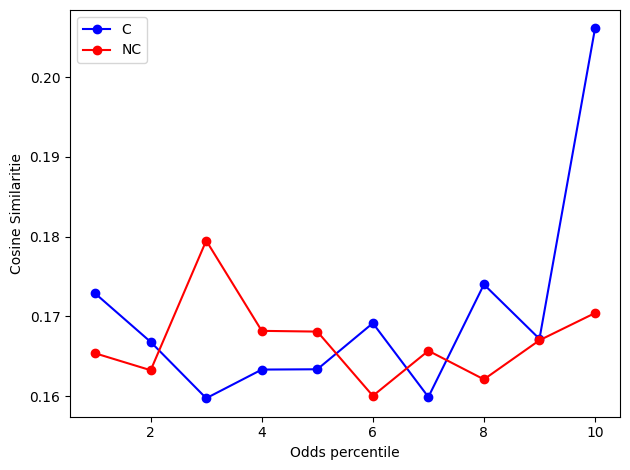

In [913]:
df_perplex_3 = df[df['perplexity']==3]

plt.plot(df_perplex_3['percentile'], df_perplex_3['cosine_similarities_C'], marker='o', label='C', color = 'blue')
plt.plot(df_perplex_3['percentile'], df_perplex_3['cosine_similarities_NC'], marker='o', label='NC', color='red')
plt.legend()

plt.xlabel('Odds percentile')
plt.ylabel('Cosine Similaritie')
plt.tight_layout()

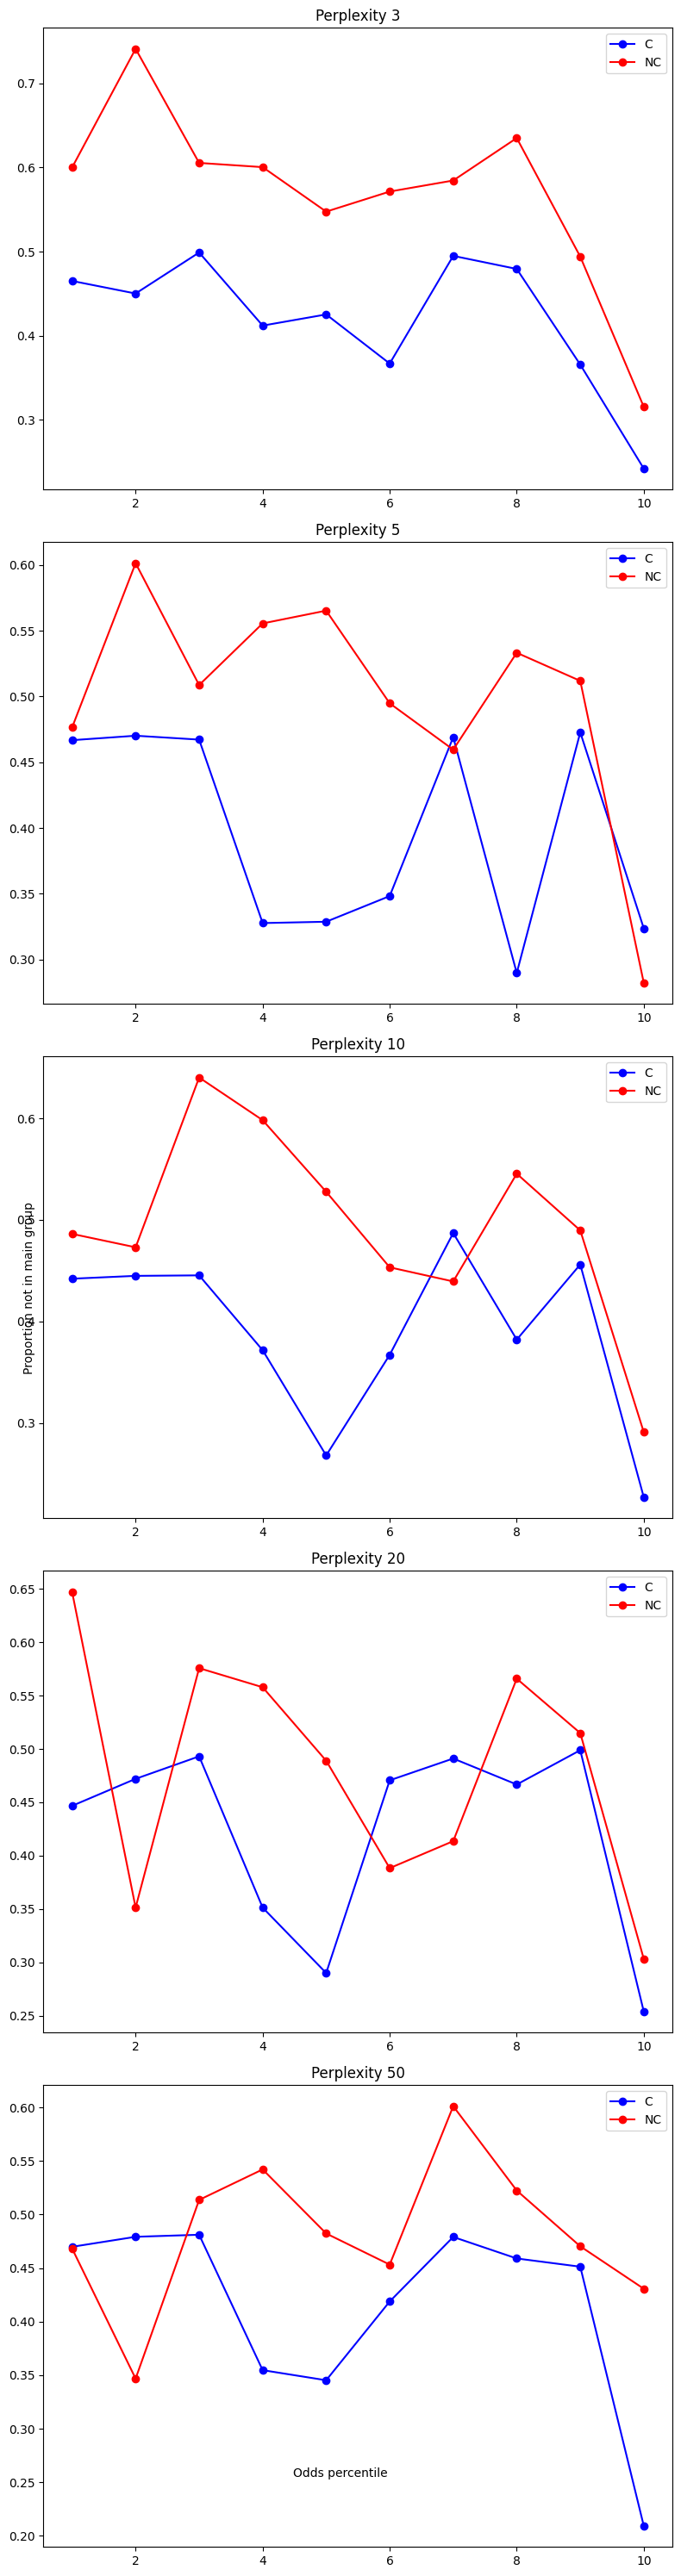

In [914]:
perplexities = df['perplexity'].unique()
fig, axes = plt.subplots(nrows=len(perplexities), ncols=1, figsize=(8, 6 * len(perplexities)))

# Plot data for each perplexity
for i, perplexity in enumerate(perplexities):
    subset = df[df['perplexity'] == perplexity]
    ax = axes[i]
    ax.plot(subset['percentile'], subset['prop_c_not_in_group_c'], marker='o', label='C', color = 'blue')
    ax.plot(subset['percentile'], subset['prop_nc_not_in_group_nc'], marker='o', label='NC', color='red')
    ax.set_title(f'Perplexity {perplexity}')
    ax.legend()

# Add common x and y axis labels
fig.text(0.5, 0.04, 'Odds percentile', ha='center')
fig.text(0.04, 0.5, 'Proportion not in main group', va='center', rotation='vertical')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

### Choose odds percentile 10 and perplexity 3

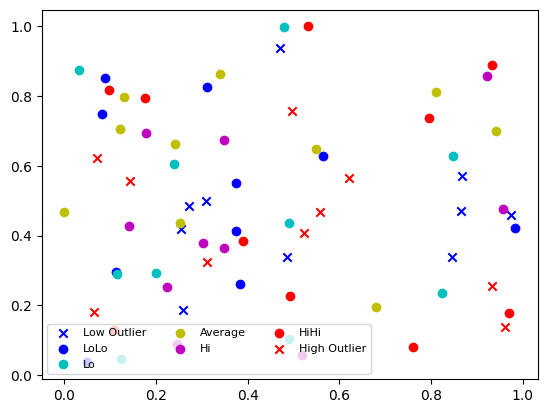

In [1069]:
import matplotlib.pyplot as plt
from numpy.random import random

colors = ['b', 'c', 'y', 'm', 'r']

lo = plt.scatter(random(10), random(10), marker='x', color=colors[0])
ll = plt.scatter(random(10), random(10), marker='o', color=colors[0])
l  = plt.scatter(random(10), random(10), marker='o', color=colors[1])
a  = plt.scatter(random(10), random(10), marker='o', color=colors[2])
h  = plt.scatter(random(10), random(10), marker='o', color=colors[3])
hh = plt.scatter(random(10), random(10), marker='o', color=colors[4])
ho = plt.scatter(random(10), random(10), marker='x', color=colors[4])

plt.legend((lo, ll, l, a, h, hh, ho),
           ('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

In [1078]:
def plot_k_means(df):
    plt.figure(figsize=(15, 15))
    df['label_numeric'] = pd.Categorical(df['classification']).codes
    
    # Map numeric labels to custom names
    #label_mapping = {0: 'False negative', 1: 'False positive', 2: 'True positive', 3: 'True negative'}  # Adjust as needed
    #df['label_name'] = df['label_numeric'].map(label_mapping)
    colors = ['b', 'c', 'y', 'm']
    
    scatter_TP = plt.scatter(x=df[df['classification']=='TP']['embedded_data1'], y=df[df['classification']=='TP']['embedded_data2'], marker='x', color=colors[0])
    scatter_TN = plt.scatter(x=df[df['classification']=='TN']['embedded_data1'], y=df[df['classification']=='TN']['embedded_data2'], marker='x', color=colors[1])
    scatter_FN = plt.scatter(x=df[df['classification']=='FN']['embedded_data1'], y=df[df['classification']=='FN']['embedded_data2'], marker='o', color=colors[2])
    scatter_FP = plt.scatter(x=df[df['classification']=='FP']['embedded_data1'], y=df[df['classification']=='FP']['embedded_data2'], marker='o', color=colors[3])
    


    #for i, row in df.iterrows():
    #    plt.text(row['embedded_data1'], row['embedded_data2'], row['word_lemma'], fontsize=6, ha='right')

    plt.legend((scatter_TP, scatter_TN, scatter_FN, scatter_FP),
           ('True positive', 'True negative', 'False negative', 'False positive'),
           loc='lower left',
           fontsize=8)

    # legend with custom names
    #legend1 = ax.legend(*scatter.legend_elements(),
    #                    loc="upper left", title="Classes")
    #ax.add_artist(legend1)

    plt.show()

C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word_lemma)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\4003398952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
C:\Users\ah140\AppData\Local\Temp\ipykernel_2848\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return m

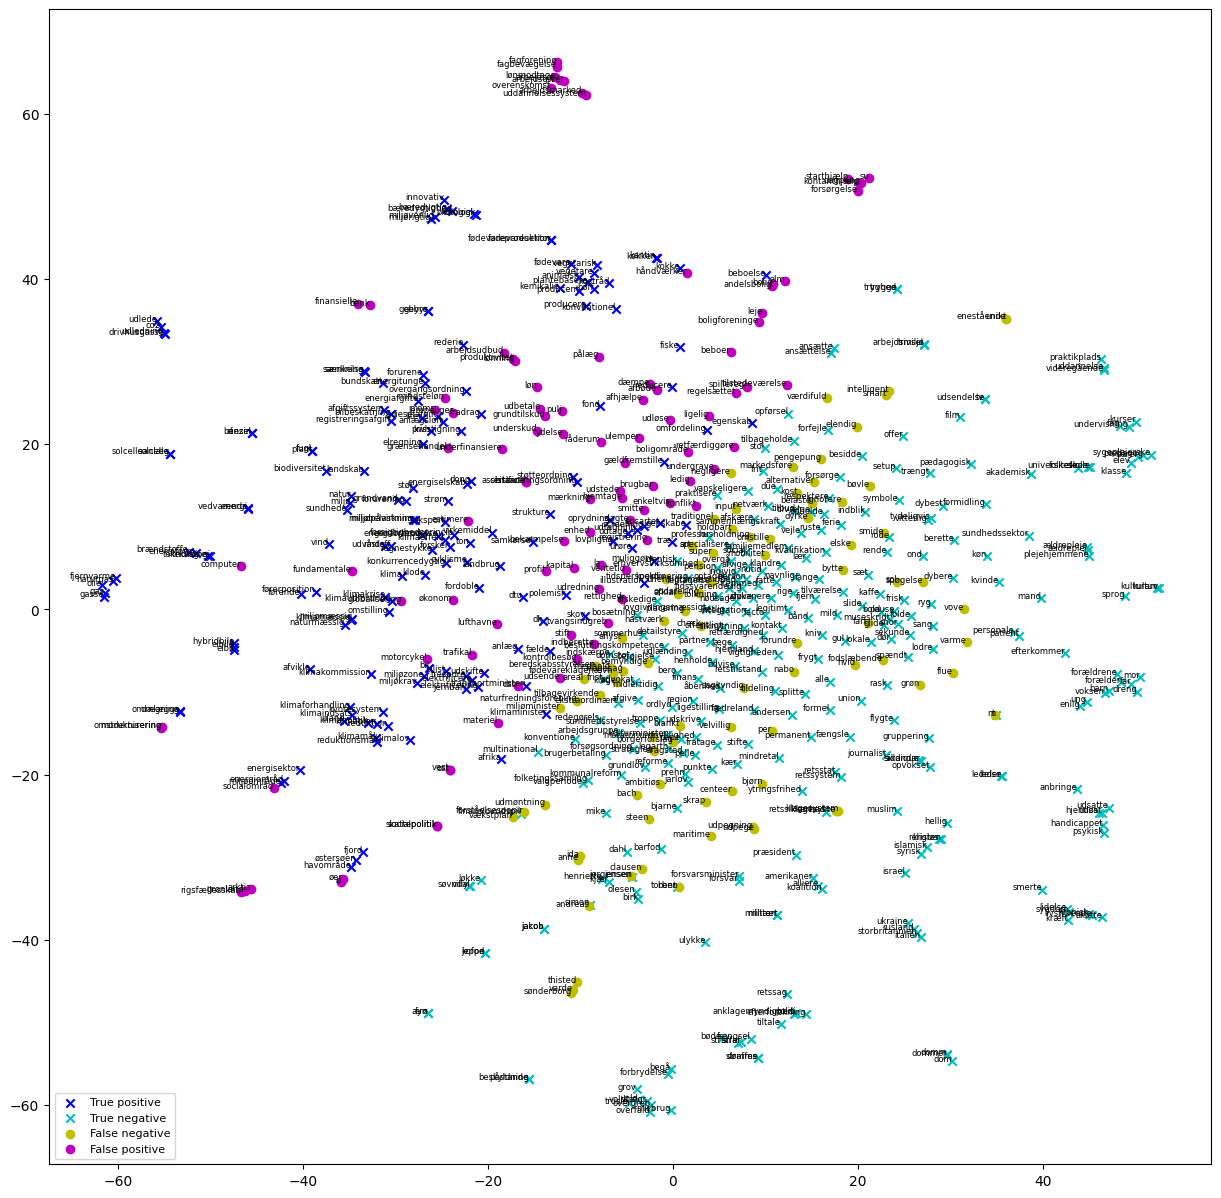

In [1079]:
percentile_10 = choose_odds_percentiles(10)
percentile_10_lemmas = percentile_10.drop_duplicates(subset='word_lemma')
percentile_10_lemmas = k_means(percentile_10_lemmas, 'tsne', 2, perplex=3)
k_means_group_c = percentile_10_lemmas[percentile_10_lemmas['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
percentile_10_lemmas['k_means_group_tsne'] = np.where(percentile_10_lemmas['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')

percentile_10_lemmas['classification'] = np.where(
    (percentile_10_lemmas['label'] == 'C') & (percentile_10_lemmas['k_means_group_tsne'] == 'C'), 'TP',
    np.where((percentile_10_lemmas['label'] == 'NC') & (percentile_10_lemmas['k_means_group_tsne'] == 'NC'), 'TN',
             np.where((percentile_10_lemmas['label'] == 'C') & (percentile_10_lemmas['k_means_group_tsne'] == 'NC'), 'FN', 'FP')))

plot_k_means(percentile_10_lemmas)
prop_c_not_in_group_c = len(percentile_10_lemmas[(percentile_10_lemmas['label']=='C') & (percentile_10_lemmas['k_means_group_tsne'] == 'NC')]) / len(percentile_10_lemmas[percentile_10_lemmas['label']=='C'])
prop_nc_not_in_group_nc = len(percentile_10_lemmas[(percentile_10_lemmas['label']=='NC') & (percentile_10_lemmas['k_means_group_tsne'] == 'C')]) / len(percentile_10_lemmas[percentile_10_lemmas['label']=='NC'])